This notebook is derived from the [scikit-bio-cookbook](http://scikit-bio.org/cookbook). It contains some experiments that I'm working on for the Phylogenetic Reconstruction chapter of [IAB](http://readIAB.org).

**Note:** This notebook requires that you've installed the [ete](http://etetoolkit.org/) package, which in turn requires PyQt4. The easiest way to install PyQt4 is using [conda](https://store.continuum.io/cshop/anaconda/) (``conda install pyqt``). The full version of conda is completely free. 

First, we'll prepare our environment and load our myoglobin alignment into a [scikit-bio ``Alignment`` object](http://scikit-bio.org/docs/latest/generated/skbio.alignment.Alignment.html).

In [1]:
%matplotlib inline

from skbio import Alignment, Protein

aln = Alignment.read('globin-aln.fasta', constructor=Protein)

In [2]:
dm = aln.distances()
print(dm)

43x43 distance matrix
IDs:
u'hemoglobin-human', u'Ornithorhynchus.anatinus-platypus', ...
Data:
[[ 0.          0.73376623  0.74025974 ...,  0.71428571  0.70779221
   0.70779221]
 [ 0.73376623  0.          0.05844156 ...,  0.24025974  0.30519481
   0.2987013 ]
 [ 0.74025974  0.05844156  0.         ...,  0.24675325  0.31818182
   0.31168831]
 ..., 
 [ 0.71428571  0.24025974  0.24675325 ...,  0.          0.24025974
   0.25324675]
 [ 0.70779221  0.30519481  0.31818182 ...,  0.24025974  0.          0.05194805]
 [ 0.70779221  0.2987013   0.31168831 ...,  0.25324675  0.05194805  0.        ]]


We currently recommend using [ete3](http://etetoolkit.org/) for tree visualization and exploration. We'll do that here, first defining a tree style, and then visualizing some trees.

In [3]:
import ete3
ts = ete3.TreeStyle()
ts.show_leaf_name = True
ts.scale =  900

## Building a neighbor joining tree

A common reason for building a multiple sequence alignment is for making an inference about the evolutionary relationships between the organisms. We'll do this here using the neighbor joining ([``nj``](http://scikit-bio.org/docs/latest/generated/skbio.tree.nj.html)) function in scikit-bio.

The input to ``nj`` is a distance matrix, representing the pairwise distances between the sequences in the alignment. This can be obtained using the ``distances`` method, which by default will compute the Hamming distances between all pairs of sequences in the alignment:

We can now build a neighbor joining tree from this distance matrix. At this point we don't have an easy and good visualization approach in scikit-bio for phylogenetic trees, though we're working on a solution. You can track progress on that [here](https://github.com/biocore/scikit-bio/issues/531).

In the meantime, we're going to export a newick-formatted version of the tree which can be opened with a phylogenetic tree viewing program. We'll show some exported images that we obtained using [Archeoptyrx](https://sites.google.com/site/cmzmasek/home/software/archaeopteryx), which works on OS X, Windows, and Linux, but there are many popular tree viewing programs, and most support the newick file format. A popular one for OS X is [FigTree](http://tree.bio.ed.ac.uk/software/figtree/). 

First, let's build the neighbor-joining tree:

In [4]:
from skbio.tree import nj
nj_tree = nj(dm)

We can then write this to file in newick format:

In [5]:
nj_tree_fp = 'globin-aln.nj.ph'
nj_tree.write(nj_tree_fp)

'globin-aln.nj.ph'

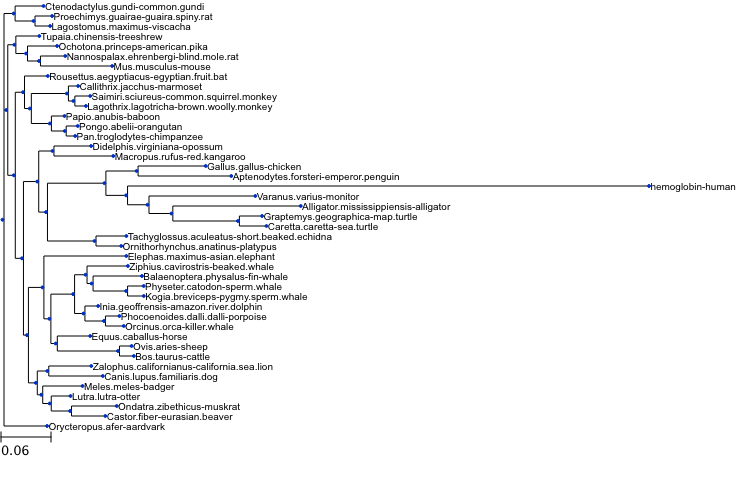

In [6]:
ete3.Tree(nj_tree_fp, format=1).render("%%inline", units="mm", tree_style=ts)

To get a better understanding of the evolutionary history, we can use outgroup rooting to place a root in the tree. When doing outgroup rooting, you want to find the tip corresponding to the most distantly related sequence in the alignment, and look at its most recent ancestral node. Because we know *a priori* that the hemoglobin sequence is the most distantly related of the sequences in our alignment (because it's not myoglobin, so by definition had to have begun diverging before all of our myoglobin sequences began diverging), you know that its first ancestral node should be the common ancestor of all sequences in the tree.

First we find the node that we want to be the new root.

In [7]:
new_root = nj_tree.find('hemoglobin-human').ancestors()[0]

And then we build a new tree rooted at this node, and write that to a new file.

In [8]:
nj_tree_rerooted = nj_tree.root_at(new_root)

You can see that this actually gives us a pretty good picture of the relationships between the organisms. For example, notice that the deepest splits are the myoglobin versus hemoglobin clades, then the separation of the reptiles, birds, and egg-laying mammals, respectively.

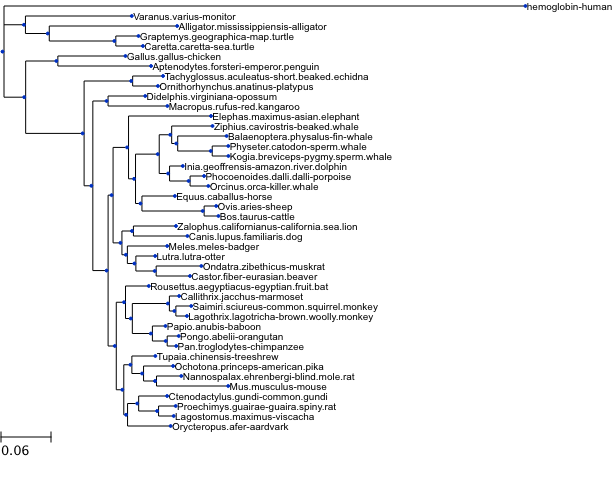

In [9]:
nj_tree_rerooted.write(nj_tree_fp)
ete3.Tree(nj_tree_fp, format=1).render("%%inline", tree_style=ts)

## Build a UPGMA tree

In [10]:
from scipy.cluster.hierarchy import average
from skbio import TreeNode
lm = average(dm.condensed_form())
upgma_tree = TreeNode.from_linkage_matrix(lm, dm.ids)
# reroot
new_root = upgma_tree.find('hemoglobin-human').ancestors()[0]
upgma_tree = upgma_tree.root_at(new_root)

In [11]:
upgma_tree_fp = 'globin-aln.upgma.ph'
upgma_tree.write(upgma_tree_fp)

'globin-aln.upgma.ph'

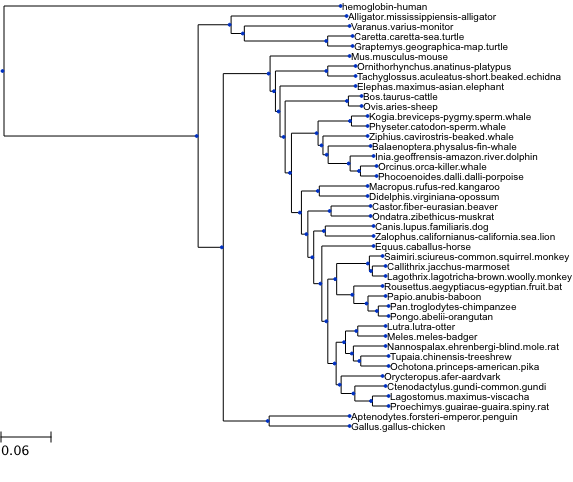

In [12]:
ete3.Tree(upgma_tree_fp, format=1).render("%%inline", units="mm", tree_style=ts)

## Build a WPGMA tree

In [13]:
from scipy.cluster.hierarchy import weighted
lm = weighted(dm.condensed_form())
wpgma_tree = TreeNode.from_linkage_matrix(lm, dm.ids)
# reroot
new_root = wpgma_tree.find('hemoglobin-human').ancestors()[0]
wpgma_tree = wpgma_tree.root_at(new_root)

In [14]:
wpgma_tree_fp = 'globin-aln.wpgma.ph'
wpgma_tree.write(wpgma_tree_fp)

'globin-aln.wpgma.ph'

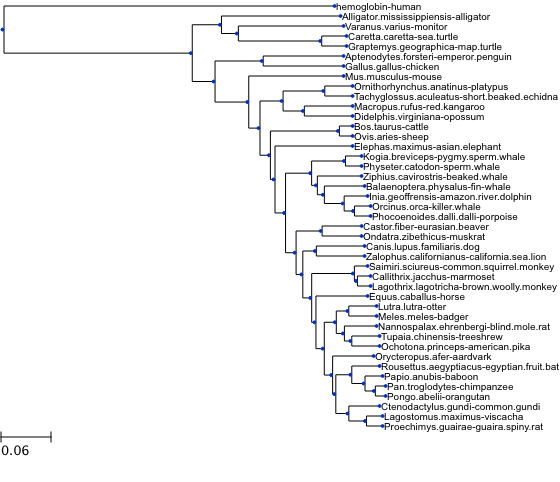

In [15]:
ete3.Tree(wpgma_tree_fp, format=1).render("%%inline", units="mm", tree_style=ts)